<a href="https://colab.research.google.com/github/chevy-67/DL-Architecture-Performance-Analysis/blob/main/Case_Study_CV_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("maxsee/v6-6500")

print("Path to dataset files:", path)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense,Flatten,Conv2D,MaxPool2D,Dropout,BatchNormalization
from keras.optimizers import Adam
from keras.utils import image_dataset_from_directory
import os
from PIL import Image
import time

**DATASET PREPROCESSING**

In [ ]:
import os
from PIL import Image

input_dir1 = 'V5Minor100/Natural'
output_dir1 = 'V5Minor100/Natural_P'
input_dir2 = 'V5Minor100/Synthetic'
output_dir2 = 'V5Minor100/Synthetic_P'
target_size = (224, 224)

def resize(inp_dir, out_dir):
    os.makedirs(out_dir, exist_ok=True)

    image_files = [f for f in os.listdir(inp_dir) if f.lower().endswith(('.jpg', '.png'))]
    total = len(image_files)

    for i, filename in enumerate(image_files, start=1):
        img_path = os.path.join(inp_dir, filename)
        output_path = os.path.join(out_dir, filename)

        try:
            with Image.open(img_path) as img:
                resized_img = img.resize(target_size)
                resized_img.save(output_path)
                print(f'\rCompleted {i}/{total}', end='', flush=True)
        except Exception as e:
            print(f"\nFailed to process {filename}: {e}")

resize(input_dir1, output_dir1)
resize(input_dir2, output_dir2)

In [ ]:
import shutil

shutil.rmtree(input_dir1)
shutil.rmtree(input_dir2)
print('Removed old data')

#**Loading the Dataset**

In [3]:
train_path = 'V5Minor100'

In [4]:
train = image_dataset_from_directory(
    train_path,
    labels='inferred',
    batch_size=32,
    image_size=(224, 224),
    seed=42,
    validation_split=0.2,
    subset="training"
)

validation = image_dataset_from_directory(
    train_path,
    labels='inferred',
    batch_size=32,
    image_size=(224, 224),
    seed=42,
    validation_split=0.2,
    subset="validation"
)

Found 6536 files belonging to 2 classes.
Using 5229 files for training.
Found 6536 files belonging to 2 classes.
Using 1307 files for validation.


##AlexNet Architecture

In [48]:
alexnet = Sequential([
    Conv2D(96, kernel_size=(11, 11), strides=5, activation='relu', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(3, 3), strides=2),

    Conv2D(256, kernel_size=(11, 11), strides=1,padding='same',activation='relu'),
    MaxPool2D(pool_size=(3, 3), strides=2),
    BatchNormalization(),

    Conv2D(384, kernel_size=(3, 3), strides=1,padding='same' ,activation='relu'),
    BatchNormalization(),

    Conv2D(384, kernel_size=(3, 3), strides=1,padding='same' ,activation='relu'),
    BatchNormalization(),

    Conv2D(256, kernel_size=(3, 3), strides=1,padding='same' ,activation='relu'),
    MaxPool2D(pool_size=(3, 3), strides=2),
    BatchNormalization(),

    Flatten(),
    Dropout(0.3),
    Dense(4096, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(4096, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

In [49]:
alexnet.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.001),metrics=['accuracy'])

In [ ]:
alex_start_time = time.time()
alex_hist = alexnet.fit(train,validation_data=validation,epochs=10,batch_size=32)
alex_end_time = time.time()

In [54]:
alexnet_time = alex_end_time-alex_start_time
print(f"AlexNet Model Training Duration : {alexnet_time/60:.2f} Min")

AlexNet Model Training Duration : 10.23 Min


In [92]:
alexnet.save('models/AlexNet.keras')

##EfficientNet Model

In [56]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,GlobalAvgPool2D

In [57]:
input_shape = (224,224,3)
effnet_base_model = EfficientNetB0(weights='imagenet',include_top=False,input_shape=input_shape)
effnet_base_model.trainable = False

In [58]:
inputs = Input(shape=input_shape)
x = effnet_base_model(inputs, training=False)
x = GlobalAvgPool2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation='sigmoid')(x)

efficient_model = Model(inputs, outputs)

In [59]:
efficient_model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.001),metrics=['accuracy'])

In [ ]:
effnet_start_time = time.time()
effnet_hist = efficient_model.fit(train,validation_data=validation,epochs=10,batch_size=32)
effnet_end_time = time.time()

In [61]:
effnet_time = effnet_end_time-effnet_start_time
print(f"EfficientNet Model Training Duration : {effnet_time/60:.2f} Min")

EfficientNet Model Training Duration : 10.34 Min


In [62]:
efficient_model.save('models/EfficientNet.keras')

##Xception Model

In [63]:
from tensorflow.keras.applications import Xception

In [64]:
xception_base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
xception_base_model.trainable = False

inputs = Input(shape=input_shape)
x = xception_base_model(inputs, training=False)
x = GlobalAvgPool2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation='sigmoid')(x)

xception_model = Model(inputs, outputs)


In [65]:
xception_model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.001),metrics=['accuracy'])

In [ ]:
x_start_time = time.time()
xcept_hist = xception_model.fit(train,validation_data=validation,epochs=10,batch_size=32,verbose=False)
x_end_time = time.time()

In [67]:
xcept_time = x_end_time-x_start_time
print(f'XceptionNet Training Duration : {xcept_time/60:.2f} Mins')

XceptionNet Training Duration : 10.31 Mins


In [68]:
xception_model.save('models/XceptionNet.keras')

##MobileNet Model

In [69]:
from tensorflow.keras.applications import MobileNet

In [70]:
mobilenet_base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
mobilenet_base_model.trainable = False

inputs = Input(shape=input_shape)
x = mobilenet_base_model(inputs, training=False)
x = GlobalAvgPool2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation='sigmoid')(x)

mobilenet_model = Model(inputs, outputs)


In [71]:
mobilenet_model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.001),metrics=['accuracy'])

In [ ]:
mob_start = time.time()
mob_hist = mobilenet_model.fit(train,validation_data=validation,epochs=10,batch_size=32,verbose=False)
mob_end = time.time()

mob_dur = mob_end-mob_start

In [73]:
print(f'MobileNet Training Duration : {mob_dur/60:.2f} Mins')

MobileNet Training Duration : 9.95 Mins


In [74]:
mobilenet_model.save('models/MobileNet.keras')

## Model Evalution

In [75]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
import warnings
import numpy as np
import os

In [93]:
mobile_model = load_model('models/MobileNet.keras')
alexnet_model = load_model('models/AlexNet.keras')
efficient_model = load_model('models/EfficientNet.keras')
xception_model = load_model('models/XceptionNet.keras')

In [94]:
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [ ]:
mob_loss,mob_acc = mobile_model.evaluate(validation,verbose=False)
alex_loss,alex_acc = alexnet_model.evaluate(validation,verbose=False)
effnet_loss,effnet_acc = efficient_model.evaluate(validation,verbose=False)
xcept_loss,xcept_acc = xception_model.evaluate(validation,verbose=False)

## Model Comparison

In [96]:
print(f'AlexNet Model \t\tAccuracy : {alex_acc:.4f}  \tLoss : {alex_loss:.4f}')
print(f'MobileNet Model \tAccuracy : {mob_acc:.4f}  \tLoss : {mob_loss:.4f}')
print(f'Efficient Model \tAccuracy : {effnet_acc:.4f}  \tLoss : {effnet_loss:.4f}')
print(f'Xception Model \t\tAccuracy : {xcept_acc:.4f}  \tLoss : {xcept_loss:.4f}')

AlexNet Model 		Accuracy : 0.7016  	Loss : 0.6340
MobileNet Model 	Accuracy : 0.7077  	Loss : 0.5805
Efficient Model 	Accuracy : 0.8240  	Loss : 0.4436
Xception Model 		Accuracy : 0.6947  	Loss : 0.5798


In [ ]:
class_reports = []

models = [alexnet_model,mobile_model,efficient_model,xception_model]
model_name = ['AlexNet','MobileNet','EfficientNet','Xception',]

for model in models:
    pred = model.predict(validation,verbose=False)
    y_pred = pred.argmax(axis=1)
    y_true = y_true = np.concatenate([labels.numpy() for _, labels in validation])
    report = classification_report(y_pred,y_true,target_names=validation.class_names)
    class_reports.append(report)

In [81]:
i = 0
for report in class_reports:
    print(model_name[i])
    print(report)
    print('\n')
    i+=1

AlexNet
              precision    recall  f1-score   support

   Natural_P       1.00      0.48      0.65      1307
 Synthetic_P       0.00      0.00      0.00         0

    accuracy                           0.48      1307
   macro avg       0.50      0.24      0.33      1307
weighted avg       1.00      0.48      0.65      1307



MobileNet
              precision    recall  f1-score   support

   Natural_P       1.00      0.48      0.65      1307
 Synthetic_P       0.00      0.00      0.00         0

    accuracy                           0.48      1307
   macro avg       0.50      0.24      0.33      1307
weighted avg       1.00      0.48      0.65      1307



EfficientNet
              precision    recall  f1-score   support

   Natural_P       1.00      0.48      0.65      1307
 Synthetic_P       0.00      0.00      0.00         0

    accuracy                           0.48      1307
   macro avg       0.50      0.24      0.33      1307
weighted avg       1.00      0.48      

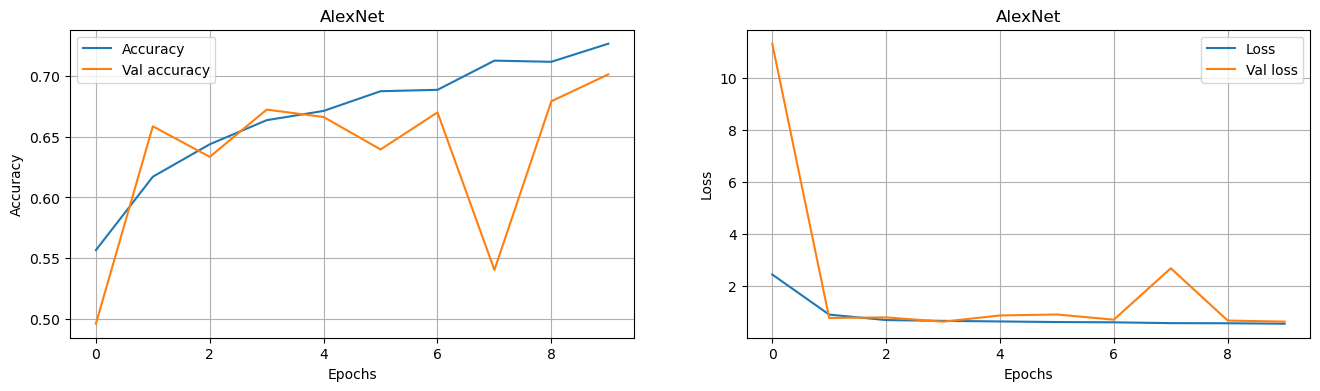

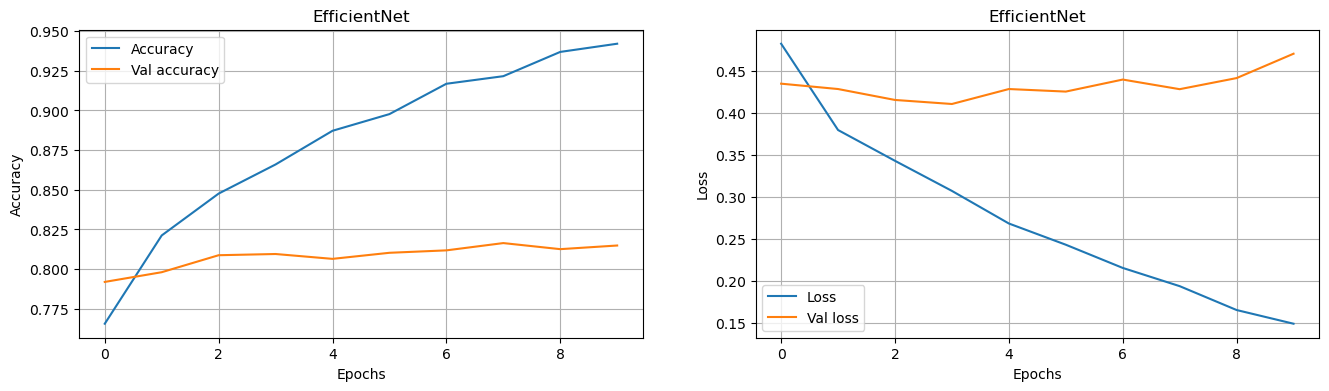

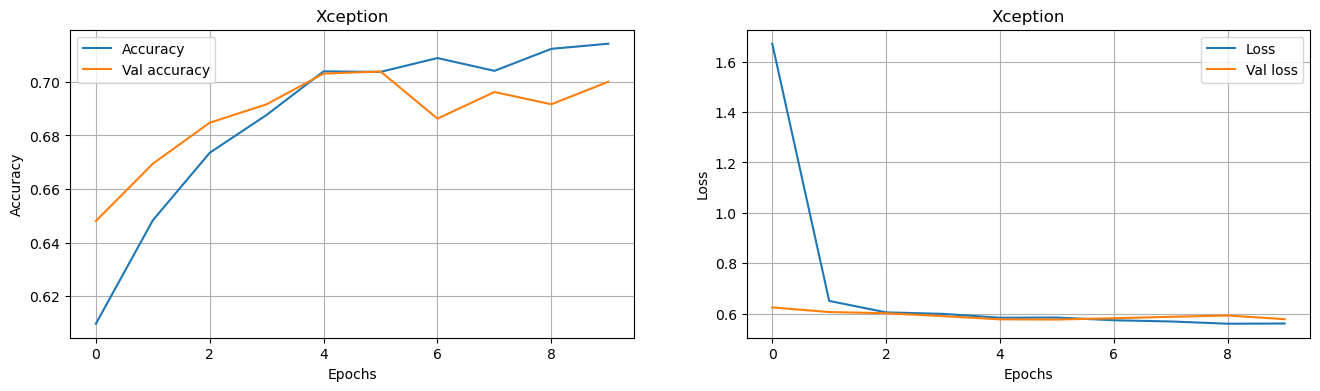

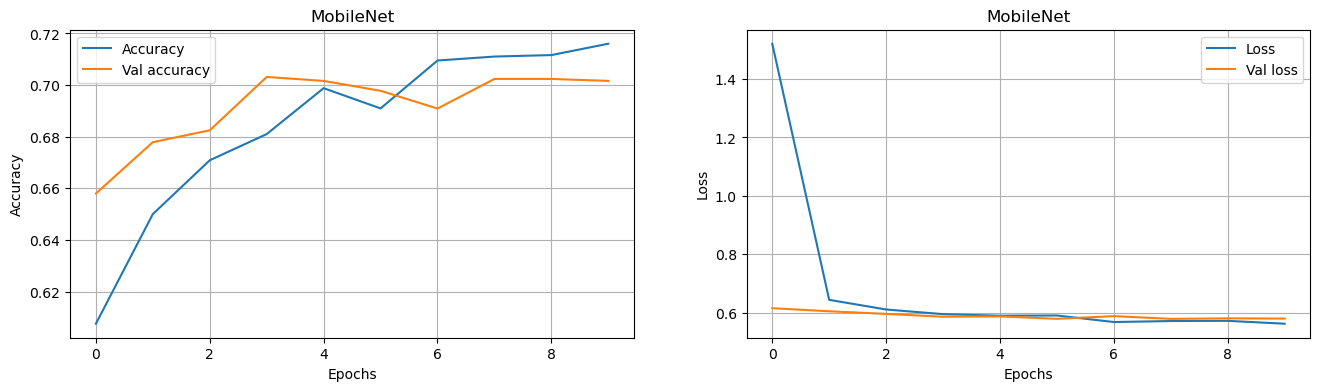

In [82]:
import matplotlib.pyplot as plt

models = [alex_hist,effnet_hist,xcept_hist,mob_hist]
model_name = ['AlexNet','EfficientNet','Xception','MobileNet']

for i,model in enumerate(models):
    plt.figure(figsize=(16,4))
    plt.subplot(1,2,1)
    plt.plot(model.history['accuracy'],label='Accuracy')
    plt.plot(model.history['val_accuracy'],label='Val accuracy')
    plt.title(f"{model_name[i]}")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(model.history['loss'],label='Loss')
    plt.plot(model.history['val_loss'],label='Val loss')
    plt.title(f"{model_name[i]}")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.savefig(f'plots/{model_name[i]}.png')
    plt.show()

In [97]:
print(f'AlexNet Training Time \t\t: {alexnet_time/60:.2f} Minutes')
print(f'EfficientNet Training Time \t: {effnet_time/60:.2f} Minutes')
print(f'XceptionNet Training Time \t: {xcept_time/60:.2f} Minutes')
print(f'MobileNet Training Time \t: {mob_dur/60:.2f} Minutes')

AlexNet Training Time 		: 10.23 Minutes
EfficientNet Training Time 	: 10.34 Minutes
XceptionNet Training Time 	: 10.31 Minutes
MobileNet Training Time 	: 9.95 Minutes


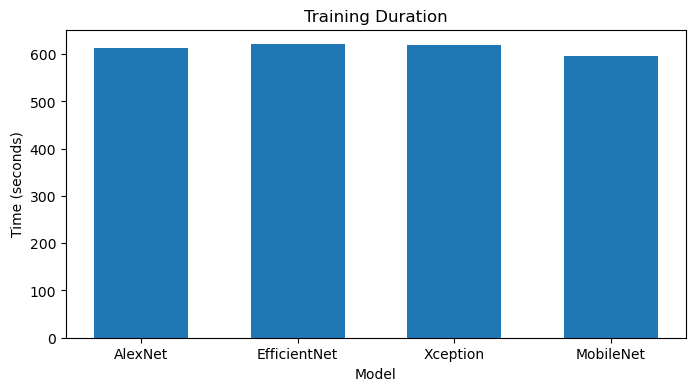

In [123]:
model_time = [alexnet_time,effnet_time,xcept_time,mob_dur]

plt.figure(figsize=(8,4))
plt.bar(model_name,model_time,width=0.6)
plt.title('Training Duration')
plt.xlabel('Model')
plt.ylabel('Time (seconds)')
plt.savefig('plots/Training Duration.png')
plt.show()

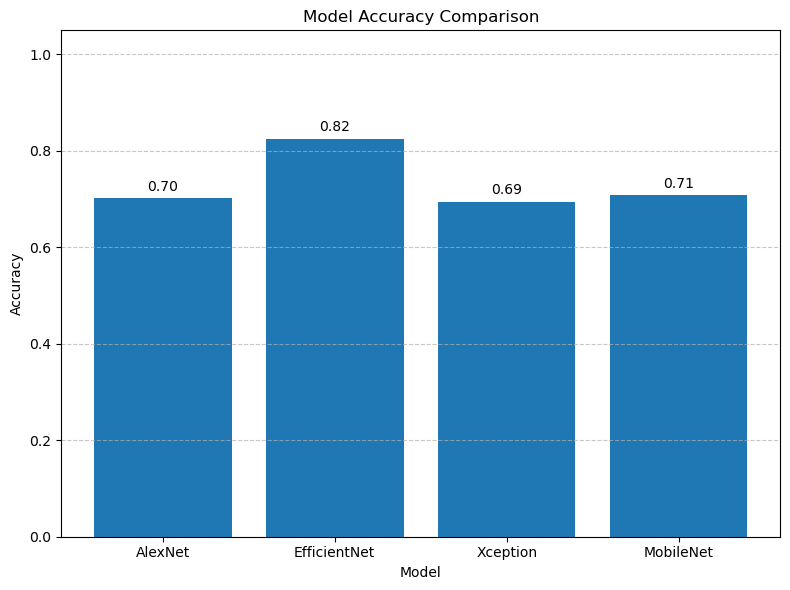

In [100]:
model_acc = [alex_acc,effnet_acc,xcept_acc,mob_acc]

plt.figure(figsize=(8, 6))
bars = plt.bar(model_name, model_acc)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f"{yval:.2f}", ha='center', va='bottom')

plt.ylim(0, 1.05)
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('plots/Overall Accuracy.png')
plt.show()